# Intel & MobileODT Cervical Cancer Screening

In [1]:
# visualization
import matplotlib.pyplot as plt
%matplotlib inline

# keras
from keras.layers.core import Dense, Dropout, Flatten, Activation
from keras.layers import BatchNormalization
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.models import save_model, load_model
from keras.callbacks import ModelCheckpoint
from keras.applications.resnet50 import ResNet50
from keras.models import Model

# image pre-processing
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import cv2

# file utils
import glob

import shutil

# utils
from datetime import datetime
import os
import numpy as np
import pandas as pd

Using TensorFlow backend.


## Definining constants

In [2]:
IMAGE_SIZE = 224
CHANNELS = 3
BATCH_SIZE = 32
NUM_EPOCH = 5
LEARN_RATE = 0.01
ALL_DIR = 'data/train'
TESTING_DIR = 'data/test'
TESTING_DIR2 = 'data/test_stg2'
VAL_DIR = 'data/val'
TR_DIR = 'data/tr'
DEBUG_DIR = 'data/debug'
SAVED_MODEL = 'subsampling.h5'
SEED = 42

split_train_valid_done = True
preload_model = os.path.isfile(SAVED_MODEL)

## Remove efix metadata
This step is only to remove a warning Keras was throwing on the train dataset for incomplete metadata. 

In [3]:
def remove_exif(files):
    tmp = []
    for file in files:
        piexif.remove(file)
            
def pre_process():
    type1 = glob.glob("{}/Type_1/*.jpg".format(ALL_DIR))
    type2 = glob.glob("{}/Type_2/*.jpg".format(ALL_DIR))
    type3 = glob.glob("{}/Type_3/*.jpg".format(ALL_DIR))
        
    remove_exif(type1)
    remove_exif(type2)
    remove_exif(type3)
    
#pre_process()

## Add additional data to training set

I've tried to use the additional data provided on Kaggle, but I didn't notice better results. The reason for this is that the additional data contains many duplicate images or low quality images. Using the ImageDataGenerator from Keras to augment the data will allow to get decent results even with the initial train dataset. 

In [4]:
# def move_files(src_dir, dest_dir):
#     for file in glob.glob(src_dir):
#         if file not in glob.glob(dest_dir):
#             shutil.copy(file,dest_dir)
            

# move_files('data/additional_Type_1_v2', 'data/train/Type_1')
# move_files('data/additional_Type_2_v2', 'data/train/Type_2')
# move_files('data/additional_Type_3_v2', 'data/train/Type_3')    

## Split training set

With this step I'm going to split the training set into training and validation step. The method below select 70% of images 
from the directory 'train' and copies the images into a new folder called 'tr'. The remaining 30% of images are copied into
a directory called 'val'

In [5]:
# credits: @daanraman https://github.com/keras-team/keras/issues/5862
def split_dataset_into_test_and_train_sets(all_data_dir, training_data_dir, testing_data_dir, testing_data_pct):
    # Recreate testing and training directories
    
    shutil.rmtree(testing_data_dir, ignore_errors=False)
    os.makedirs(testing_data_dir)
    print("Successfully cleaned directory " + testing_data_dir)

    shutil.rmtree(training_data_dir, ignore_errors=False)
    os.makedirs(training_data_dir)
    print("Successfully cleaned directory " + training_data_dir)

    num_training_files = 0
    num_testing_files = 0

    for subdir, dirs, files in os.walk(all_data_dir):
        category_name = os.path.basename(subdir)

        # Don't create a subdirectory for the root directory
        print(category_name + " vs " + os.path.basename(all_data_dir))
        if category_name == os.path.basename(all_data_dir):
            continue

        training_data_category_dir = training_data_dir + '/' + category_name
        testing_data_category_dir = testing_data_dir + '/' + category_name

        if not os.path.exists(training_data_category_dir):
            os.mkdir(training_data_category_dir)

        if not os.path.exists(testing_data_category_dir):
            os.mkdir(testing_data_category_dir)

        for file in files:
            input_file = os.path.join(subdir, file)
            if np.random.rand(1) < testing_data_pct:
                shutil.copy(input_file, testing_data_dir + '/' + category_name + '/' + file)
                num_testing_files += 1
            else:
                shutil.copy(input_file, training_data_dir + '/' + category_name + '/' + file)
                num_training_files += 1

    print("Processed " + str(num_training_files) + " training files.")
    print("Processed " + str(num_testing_files) + " testing files.")


In [6]:
if not split_train_valid_done:
    split_dataset_into_test_and_train_sets(ALL_DIR, TR_DIR, VAL_DIR, 0.3)

## Augment data

In this step I'm going to use the ImageDataGenerator method from Keras to augment the training data and rescale all images by a factory of 1.0/255.0

I'm going to call the flow_from_directory method to create a generator for the train and validation data that I'm going to use later to train the model. 

In [7]:
def create_data_generators(validation_set = False):
    if not validation_set:
        data_generator = ImageDataGenerator(rescale=1./255.,
        horizontal_flip=True, fill_mode="nearest")
        
        return data_generator.flow_from_directory(TR_DIR, target_size=(IMAGE_SIZE, IMAGE_SIZE), shuffle=True, seed=SEED,
                                                         class_mode='categorical', batch_size=BATCH_SIZE)
    else:
        valid_data_generator = ImageDataGenerator(rescale=1./255)
        return valid_data_generator.flow_from_directory(VAL_DIR, target_size=(IMAGE_SIZE, IMAGE_SIZE), shuffle=True, seed=SEED,
                                                         class_mode='categorical', batch_size=BATCH_SIZE)
        


train_generator = create_data_generators()
validation_generator = create_data_generators(True)

step_size_train=train_generator.n//BATCH_SIZE
step_size_valid=validation_generator.n//BATCH_SIZE

print(step_size_train, step_size_valid)


Found 4291 images belonging to 3 classes.
Found 2040 images belonging to 3 classes.
134 63


## Build the model

In this step instead of building a model from scratch I'm going to use the weights of a pretrained model called ResNet50 that I can download from the Keras library. The output of this model will be the input layer of my model . 

I'm also using dropout to reduce the risk of overfitting. 

In [8]:
def build_model():
    base_model = ResNet50(include_top=False, weights=None, input_tensor=None, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
    x = Flatten()(base_model.output)
    
    x = Dense(32)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
#     x = Dense(64)(x)
#     x = BatchNormalization()(x)
#     x = Activation('relu')(x)
#     x = Dropout(0.5)(x)

    output = Dense(3, activation='softmax')(x)
    
    model = Model(inputs=base_model.input, outputs=output)
    
    model.summary()
    return model

# def build_model():
#     base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=None, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
#     output = base_model.get_layer(index = -1).output
#     output = Flatten(name='flatten')(output)
#     output = Dense(3, activation='softmax', name='predictions')(output)
#     model = Model(base_model.input, output)
#     model.summary()
#     return model

def load_model_from_file(file):
    return load_model(file)

def compile_model(model):
    opt4 = optimizers.Adam(lr=LEARN_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer=opt4, loss='categorical_crossentropy', metrics=['accuracy'])  


model = build_model()
compile_model(model)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:263: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

## Train the model

In [9]:
def train_model(model, train_generator, validation_generator, step_train, step_valid):
    checkpoint = ModelCheckpoint(SAVED_MODEL,  
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only= True,
                             mode='auto') 
                        
    
    history = model.fit_generator(
            train_generator,
            steps_per_epoch=step_train,
            epochs=NUM_EPOCH,
            callbacks=[checkpoint],
            validation_data=validation_generator,
            validation_steps=step_valid)
            
    model.save(SAVED_MODEL)
    return history

history = train_model(model, train_generator, validation_generator, step_size_train, step_size_valid)

Epoch 1/5
 89/134 [==================>...........] - ETA: 5:01 - loss: 1.1953 - acc: 0.3861

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 524288 bytes but only got 0. Skipping tag 3
  " Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 393216 bytes but only got 0. Skipping tag 3
  " Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 33554432 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 25165824 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), ta

133/134 [============================>.] - ETA: 6s - loss: 1.1667 - acc: 0.3820 

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 521601024 bytes but only got 0. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/TiffImagePlugin.py:747: UserWarning: Possibly corrupt EXIF data.  Expecting to read 205914112 bytes but only got 11101. Skipping tag 4
  " Skipping tag %s" % (size, len(data), tag))


134/134 [==============================] - 1234s 9s/step - loss: 1.1662 - acc: 0.3815 - val_loss: 1.1456 - val_acc: 0.4319

Epoch 00001: val_loss improved from inf to 1.14560, saving model to subsampling.h5
Epoch 2/5
134/134 [==============================] - 1215s 9s/step - loss: 1.0718 - acc: 0.4125 - val_loss: 1.1305 - val_acc: 0.4113

Epoch 00002: val_loss improved from 1.14560 to 1.13050, saving model to subsampling.h5
Epoch 3/5
134/134 [==============================] - 1207s 9s/step - loss: 1.0481 - acc: 0.4390 - val_loss: 1.0553 - val_acc: 0.4358

Epoch 00003: val_loss improved from 1.13050 to 1.05530, saving model to subsampling.h5
Epoch 4/5
134/134 [==============================] - 1222s 9s/step - loss: 1.0510 - acc: 0.4433 - val_loss: 1.0525 - val_acc: 0.4392

Epoch 00004: val_loss improved from 1.05530 to 1.05253, saving model to subsampling.h5
Epoch 5/5
134/134 [==============================] - 1199s 9s/step - loss: 1.0422 - acc: 0.4461 - val_loss: 1.0306 - val_acc: 0.45

## Visualize tranining history

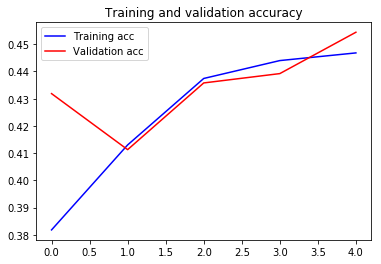

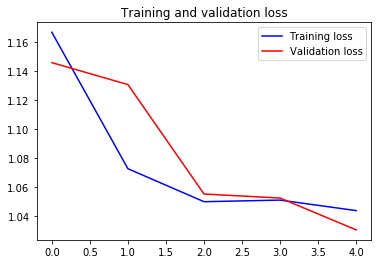

In [10]:
def visualize_train_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

if history != None:
    visualize_train_history(history)

## Evaluate

In [11]:
def create_data_generator_from_array(raw_data, batch_size, folder, evaluate=False):
    labels = ["Type_1", "Type_2", "Type_3"]
    while True:
        X = np.zeros((batch_size, IMAGE_SIZE, IMAGE_SIZE, CHANNELS), dtype=np.float32)
        Y = np.zeros((batch_size, 3), dtype=np.float32)
        cnt = 0
        for i, (image_name, image_class) in enumerate(raw_data):
            file_path = os.path.join(folder,image_class, image_name + '.jpg')        
            
            image = cv2.imread(file_path)
            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
            #image = image.transpose([2,0,1])
            image = image.astype(np.float32) / 255.0
            X[cnt, :, :, :] = image
            class_index = labels.index(image_class)
            Y[cnt, class_index] = 1
                
            cnt += 1
            if cnt == batch_size:
                yield (X, Y)
                X = np.zeros((batch_size, IMAGE_SIZE, IMAGE_SIZE, CHANNELS), dtype=np.float32)
                Y = np.zeros((batch_size, 3), dtype=np.float32)
                cnt = 0

        if cnt > 0:
            X = X[:cnt,:,:,:]
            Y = Y[:cnt,:]

            yield (X, Y) 
        
        if evaluate:
            break


def validation_iterator(evaluate=False):
    type1 = glob.glob("{}/Type_1/*.jpg".format(VAL_DIR))
    type2 = glob.glob("{}/Type_2/*.jpg".format(VAL_DIR))
    type3 = glob.glob("{}/Type_3/*.jpg".format(VAL_DIR))
    
    type1_filenames = extract_filename(type1)
    type2_filenames = extract_filename(type2)
    type3_filenames = extract_filename(type3)
    all_filenames = [type1_filenames, type2_filenames, type3_filenames]
    
    valid_sizes = [int(len(ids) * 1) for ids in all_filenames]
    
    
    valid_type1 = type1_filenames[:valid_sizes[0]]
    valid_type2 = type2_filenames[:valid_sizes[1]]
    valid_type3 = type3_filenames[:valid_sizes[2]]

    
    labels = ["Type_1", "Type_2", "Type_3"]

    valid_all = []
    

    #train
    for img in valid_type1:
        valid_all.append((img, labels[0]))

    for img in valid_type2:
        valid_all.append((img, labels[1]))

    for img in valid_type3:
        valid_all.append((img, labels[2]))

    
    
    validation_iter =  create_data_generator_from_array(valid_all, BATCH_SIZE, VAL_DIR, evaluate)
    
    return validation_iter

def extract_filename(files):
    tmp = []
    for file in files:
        parts = file.split('/')
        tmp.append(parts[-1].replace('.jpg', ''))
    return np.array(tmp)

def evaluate_model(model, validation_generator):
    total_loss = 0.0
    total_counter = 0 

    for X, Y_true in validation_generator:

        s = Y_true.shape[0]
        total_counter += s

        Y_pred = model.predict(X)
        loss = logloss_mc(Y_true.astype(np.int), Y_pred)
        print("--", total_counter, "batch loss : ", loss)
        total_loss += s * loss
    
    if (total_counter > 0):
        total_loss *= 1.0 / total_counter   
    return total_loss

def logloss_mc(y_true, y_prob, epsilon=1e-15):
    """ Multiclass logloss
    This function is not officially provided by Kaggle, so there is no
    guarantee for its correctness.
    https://github.com/ottogroup/kaggle/blob/master/benchmark.py
    """
    # normalize
    y_prob = y_prob / y_prob.sum(axis=1).reshape(-1, 1)
    y_prob = np.maximum(epsilon, y_prob)
    y_prob = np.minimum(1 - epsilon, y_prob)
    # get probabilities
    y = [y_prob[i, j] for (i, j) in enumerate(y_true)]
    ll = - np.mean(np.log(y))
    return ll

vg = validation_iterator(True) 

total_loss = evaluate_model(model, vg)
print("Total loss : ", total_loss)

-- 32 batch loss :  2.7963667
-- 64 batch loss :  2.467375
-- 96 batch loss :  2.5658417
-- 128 batch loss :  1.8912457
-- 160 batch loss :  2.5922816
-- 192 batch loss :  2.246125
-- 224 batch loss :  2.3751962
-- 256 batch loss :  2.3854787
-- 288 batch loss :  2.8032773
-- 320 batch loss :  2.3399842
-- 352 batch loss :  2.5843577
-- 384 batch loss :  2.4201672
-- 416 batch loss :  2.5313475
-- 448 batch loss :  2.2981238
-- 480 batch loss :  2.6213152
-- 512 batch loss :  2.2140324
-- 544 batch loss :  2.1273036
-- 576 batch loss :  2.7112484
-- 608 batch loss :  2.1662848
-- 640 batch loss :  2.3788826
-- 672 batch loss :  2.5247443
-- 704 batch loss :  2.0630825
-- 736 batch loss :  2.0831645
-- 768 batch loss :  1.8994652
-- 800 batch loss :  2.1034162
-- 832 batch loss :  2.1692424
-- 864 batch loss :  2.0012472
-- 896 batch loss :  2.5524883
-- 928 batch loss :  2.0394738
-- 960 batch loss :  1.811933
-- 992 batch loss :  2.1692138
-- 1024 batch loss :  2.3481889
-- 1056 batch

## Prediction on test dataset


In [12]:
def get_test_dataset_iter(raw_data, batch_size, folder):
    labels = ["Type_1", "Type_2", "Type_3"]
    while True:
        X = np.zeros((batch_size, IMAGE_SIZE, IMAGE_SIZE, CHANNELS), dtype=np.float32)
        Y = np.empty((batch_size,), dtype=np.object)
        cnt = 0
        for i, (image_name, image_class) in enumerate(raw_data):
            if image_class == 'Test':
                file_path = os.path.join(folder, image_name + '.jpg')
            else: 
                file_path = os.path.join(TESTING_DIR2, image_name + '.jpg')
            
            image = cv2.imread(file_path)

            image = cv2.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
            #image = image.transpose([2,0,1])
            image = image.astype(np.float32) / 255.0
            X[cnt, :, :, :] = image
            Y[cnt] = str(image_name)
            cnt += 1
            if cnt == batch_size:
                yield (X, Y)
                X = np.zeros((batch_size, IMAGE_SIZE, IMAGE_SIZE, CHANNELS), dtype=np.float32)
                Y = np.empty((batch_size,), dtype=np.object)
                cnt = 0

        if cnt > 0:
            X = X[:cnt,:,:,:]
            Y = Y[:cnt]

            yield (X, Y) 

        break
        
def gen_submission_dataframe(model, test_iter):
    df = pd.DataFrame(columns=['image_name','Type_1','Type_2','Type_3'])
    cnt = 0
    for X, Y in test_iter:
        y_pred = model.predict(X)
        s = X.shape[0]

        for i in range(s):
            df.loc[cnt + i, :] = (Y[i] + '.jpg', ) + tuple(y_pred[i, :])
        cnt += s 
    return df
        
def make_predictions(model):
    test = glob.glob("{}/*.jpg".format(TESTING_DIR))
    test2 = glob.glob("{}/*.jpg".format(TESTING_DIR2))

    test_filenames = extract_filename(test)
    test_filenames2 = extract_filename(test2)

    test_all = []
    for img in test_filenames:
        test_all.append((img, 'Test'))

    for img in test_filenames2:
        test_all.append((img, 'Test2'))
    
    test_iter = get_test_dataset_iter(test_all, BATCH_SIZE, TESTING_DIR)
    
    
    return gen_submission_dataframe(model, test_iter)
    
def save_submission(df):

    sub_file = 'submission_' + str(datetime.now().strftime("%Y-%m-%d-%H-%M")) + '.csv'
    df.to_csv(sub_file, index=False)

def load_model_from_file(file):
    return load_model(file)

df = make_predictions(model)
save_submission(df)

In [13]:
df.shape

(4018, 4)